In [17]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
import calendar

In [6]:
article_csv_files = glob.glob('../nyt_corpus/csvs/*')
article_df = pd.read_csv(article_csv_files[0], index_col=0)

Articles in One Year

In [348]:
article_df.shape

(106104, 18)

# EDA

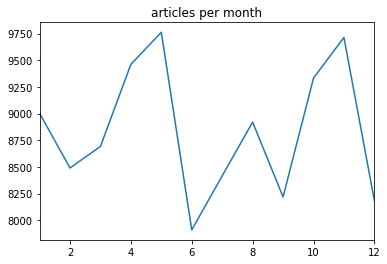

In [30]:
article_df['publication_month'].value_counts().sort_index().plot(title='articles per month')

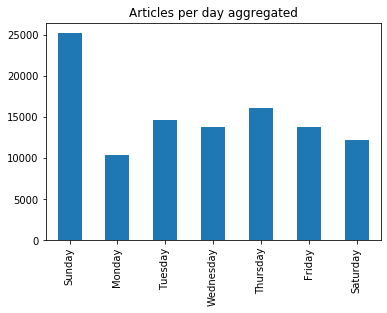

In [31]:
days_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
article_df['publication_day_of_week'].value_counts()[days_of_week].plot(kind='bar', title="Articles per day aggregated")

Text(0.5, 0, 'Article Count')

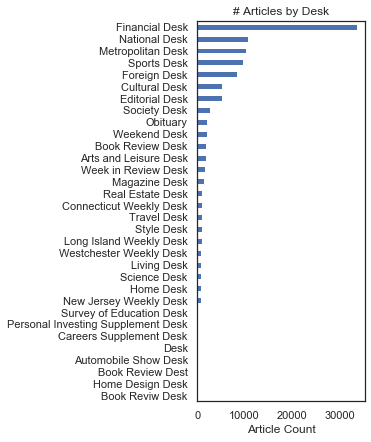

In [311]:
article_df['dsk'].value_counts().iloc[::-1].plot(kind='barh', figsize=(3,7),title='# Articles by Desk')
plt.xlabel('Article Count')

# Articles by Print Section

In [132]:
article_df['print_section'].value_counts()[:15]

D       28990
1       21359
A       18631
C       10230
B        9706
4        2358
5        2239
7        1860
2        1815
6        1450
3        1266
8        1088
11CN     1080
10        996
11LI      941
Name: print_section, dtype: int64

## Articles by desk in top sections

In [312]:
(article_df
 .loc[lambda df: df['print_section'].isin(df['print_section'].value_counts()[:5].index)]
 .dsk.value_counts()
)

Financial Desk              32176
National Desk               10699
Metropolitan Desk           10239
Foreign Desk                 8444
Sports Desk                  7414
Cultural Desk                5230
Editorial Desk               4442
Society Desk                 2760
Obituary                     2067
Weekend Desk                 1985
Style Desk                    975
Living Desk                   821
Science Desk                  812
Home Desk                     810
Desk                           28
Magazine Desk                  10
Survey of Education Desk        1
Real Estate Desk                1
Careers Supplement Desk         1
Arts and Leisure Desk           1
Name: dsk, dtype: int64

In [124]:
### what is section "1"?

### Articles by Day in each Section

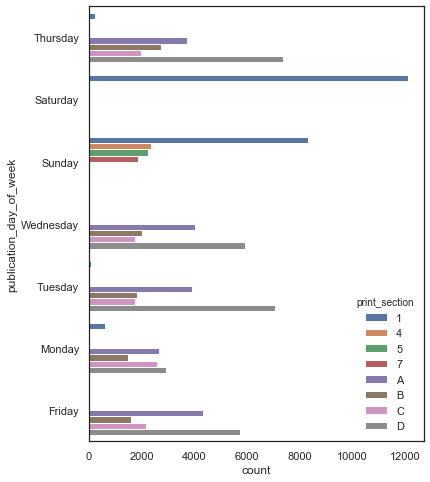

In [191]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "legend.frameon": False})
plt.figure(figsize=(6, 8))
ax = sns.countplot(
    hue="print_section", 
    y="publication_day_of_week", 
    data=(article_df
          .loc[lambda df: df['print_section'].isin(df['print_section'].value_counts()[:8].index)]
          .sort_values('print_section')
         )
)

### Articles by Desk in each section

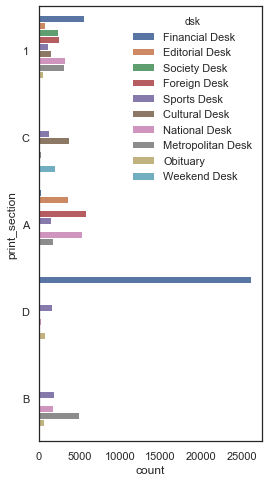

In [156]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "legend.frameon": False})
plt.figure(figsize=(4, 8))
ax = sns.countplot(
    y="print_section", 
    hue="dsk", 
    data=(article_df
          .loc[lambda df: df['print_section'].isin(df['print_section'].value_counts()[:5].index)]
          .loc[lambda df: df['dsk'].isin(df['dsk'].value_counts()[:10].index)]
         )
)

## Look at section over time

In [59]:
article_df['pub_date'] = (article_df
    .apply(lambda x: datetime(x['publication_year'], x['publication_month'], x['publication_day_of_month']), axis=1)
)

article_df['pub_date_float'] = article_df['pub_date'].dt.dayofyear

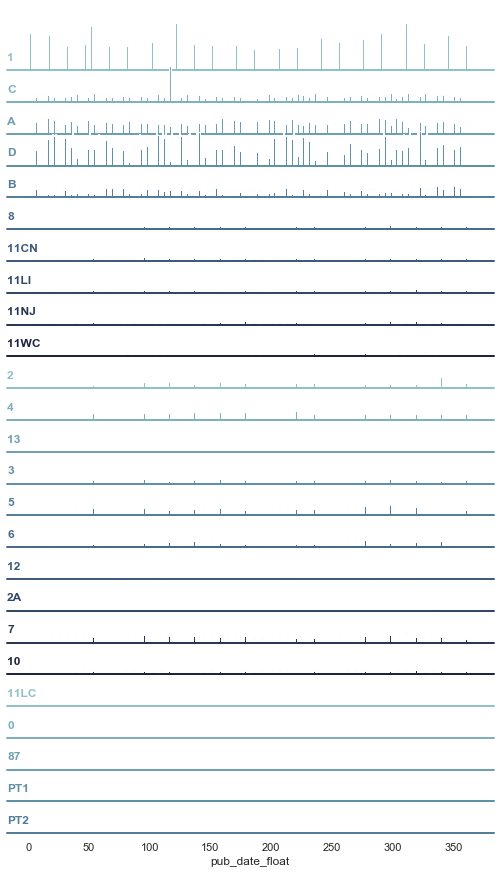

In [354]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(article_df, row="print_section", hue="print_section", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(plt.hist, "pub_date_float", bins=365)#, clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
# g.map(plt.hist, "pub_date_float", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

g.map(label, "pub_date_float")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

# reformat print page so it's section + page

In [116]:
article_df['print_section_and_page'] = (article_df
 .loc[lambda x: x['print_page_number'].notnull()]
 .apply(lambda x: '%s-%03.f' % (x['print_section'] , int(x['print_page_number'])), axis=1)
)

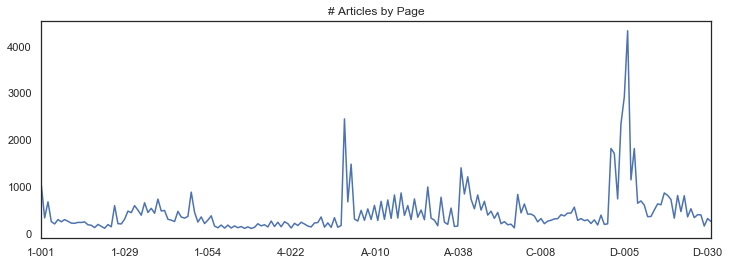

In [333]:
(article_df['print_section_and_page']
 .value_counts()
 .sort_index()
 .loc[lambda x: x>100]
 .plot(figsize=(12, 4), title="# Articles by Page")
)

In [313]:
article_df['print_section_and_page'].value_counts().head()

D-006    4329
D-005    2912
A-001    2444
D-004    2340
D-001    1812
Name: print_section_and_page, dtype: int64

In [340]:
newspaper_size_by_day = article_df.groupby('pub_date')['print_section_and_page'].unique().str.len().iloc[:-1]

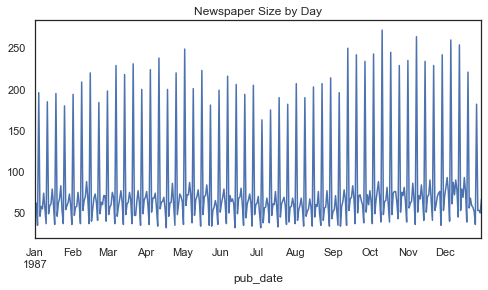

In [341]:
newspaper_size_by_day.plot(figsize=(8,4), title="Newspaper Size by Day")

Text(0.5, 1.0, 'Newspaper Size, Histogram')

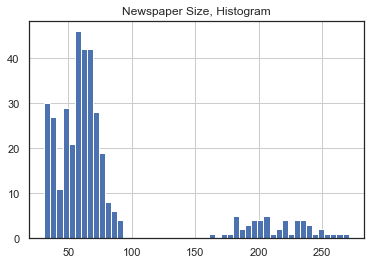

In [345]:
newspaper_size_by_day.hist(bins=50)
plt.title("Newspaper Size, Histogram")

# Try some vanilla classification

In [212]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

### prepare data

In [192]:
data_df = article_df.loc[lambda df: df['print_section'].isin(['A', 'B', 'C', 'D'])]

In [194]:
data_df['print_section_and_page'].value_counts().loc[lambda x: x>500].head()

D-006    4329
D-005    2912
A-001    2444
D-004    2340
D-001    1812
Name: print_section_and_page, dtype: int64

In [195]:
y = data_df['print_section_and_page']
X = data_df['body']

### Train/Test

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
lr_pipe = Pipeline([
    ('cv', CountVectorizer(min_df=.01, max_df=.4)),
    ('lr', LogisticRegression())
])

In [215]:
lr_pipe.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('cv',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.4,
                                 max_features=None, min_df=0.01,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                          

In [218]:
y_pred = lr_pipe.predict_proba(X_test)

In [225]:
y_pred_df = pd.DataFrame(y_pred, index=X_test.index, columns=dict(lr_pipe.steps)['lr'].classes_)

### Calculate AUCs

In [236]:
aucs = {}
for col in y_pred_df.columns:
    y_pred_score = y_pred_df[col]
    y_true = (y_test == col).astype(int)
    if len(y_true.unique()) > 1:
        aucs[col] = roc_auc_score(y_true, y_pred_score)

In [248]:
pd.merge(
    pd.Series(aucs).sort_values().to_frame('auc'),
    y_test.value_counts().to_frame('counts'),
    left_index=True,
    right_index=True
)

,auc,counts
B-029,0.372432,1
B-023,0.422929,3
A-037,0.424434,4
B-017,0.526724,10
B-024,0.555842,24
B-018,0.588840,15
B-021,0.590407,9
A-033,0.604310,24
B-032,0.642637,8
A-020,0.643937,135


# Explore Coefficients

In [276]:
pipe_steps = dict(lr_pipe.steps)
coef_df = pd.DataFrame(
    pipe_steps['lr'].coef_,
    columns=pd.Series(pipe_steps['cv'].vocabulary_).sort_values().index,
    index=pipe_steps['lr'].classes_
).T

Text(0.5, 0, 'Coefficient')

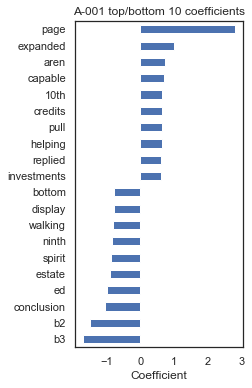

In [293]:
top_k = 10
figsize= (3,6)
page = 'A-001'


(coef_df[page]
 .sort_values()
 .pipe(lambda s: pd.concat([s[:top_k], s[-top_k:]]))
 .plot(kind='barh', figsize=figsize, title='%s top/bottom %d coefficients' % (page, top_k))
)
plt.xlabel('Coefficient')

Text(0.5, 0, 'Coefficient')

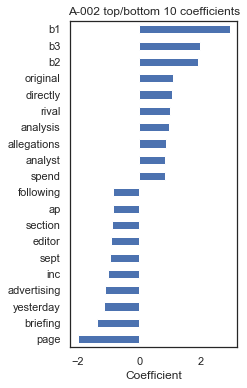

In [295]:
top_k = 10
figsize= (3,6)
page = 'A-002'

(coef_df[page]
 .sort_values()
 .pipe(lambda s: pd.concat([s[:top_k], s[-top_k:]]))
 .plot(kind='barh', figsize=figsize, title='%s top/bottom %d coefficients' % (page, top_k))
)
plt.xlabel('Coefficient')

In [303]:
print(article_df
 .loc[lambda df: df['print_section_and_page'] == 'A-002']
 .loc[lambda df: df['body'].str.contains('B2')]
 ['body'].iloc[0]
)



LEAD: International


LEAD: International
International
A3-13
A partisan dispute on Iran inquiries erupted in the Senate when Democrats and Republicans disagreed sharply over the release of a committee report and the mandate of a new panel.
A1
Bonn rejected an Iran deal last year when it told a West German aerospace company that it would not be allowed to sell 12 transport aircraft to Iran until at least the end of the Iran-Iraq war.
A10
An Italian official was disillusioned at first by the news that Washington secretly sold arms to Iran. Now Defense Minister Giovanni Spadolini's thoughts focus on the need for remedial action.
A13
Washington may have approved arms sales to Iran, according to an associate of the Saudi arms dealer Adnan M. Khashoggi who claims he was told of such approval before he began selling arms to Teheran, the associate's lawyers asserted.
A10
Cardinal O'Connor ended his visit to Jordan and Israel and expressed concern about the poverty and statelessness of Pales

# Loop through all files

In [ ]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
print_sections = ['A', 'B', 'C', 'D', 'E', '1', '2', '3', '4']

for fname in tqdm(glob.glob('../nyt_corpus/csvs/*')):
    year = os.path.basename(fname).replace('.csv', '')
    article_df = pd.read_csv(fname, index_col=0)
    article_df['publication_day_of_week'] = (
        article_df['publication_day_of_week']
        .astype('category')
        .cat.set_categories(weekdays, ordered=True)
    )
    article_df['print_section'] = (
        article_df['print_section']
        .astype('category')
        .cat.set_categories(print_sections, ordered=True)
    )
        
    ## plot top 10 sections
    article_df['print_section'].value_counts().head(10).plot(kind='bar', title="articles by section, %s" % year)
    plt.savefig('exploratory_analysis/articles_by_section_%s.pdf' % year, bbox_inches="tight")
    plt.savefig('exploratory_analysis/articles_by_section_%s.png' % year, bbox_inches="tight")
    plt.close()
    
    ## plot section by day-of-week 
    plt.figure(figsize=(6, 8))
    ax = sns.countplot(
        hue="print_section", 
        y="publication_day_of_week", 
        data=(article_df
              .loc[lambda df: df['print_section'].isin(print_sections)]
              .sort_values('print_section')
              .sort_values('publication_day_of_week')
             )
    )
    plt.title("section by day of week, %s" % year)
    plt.savefig("exploratory_analysis/section_by_day_of_week_%s.pdf" % year, bbox_inches='tight')
    plt.savefig("exploratory_analysis/section_by_day_of_week_%s.png" % year, bbox_inches='tight')
    plt.close()

    ## plot section by desk
    plt.figure(figsize=(6, 8))
    ax = sns.countplot(
        y="print_section", 
        hue="dsk", 
        data=(article_df
              .loc[lambda df: df['print_section'].isin(print_sections)]
              .loc[lambda df: df['dsk'].isin(df['dsk'].value_counts()[:10].index)]
              .sort_values('print_section')
              .sort_values('publication_day_of_week')
             )
    )
    plt.legend(bbox_to_anchor=(1., .5))
    plt.title("section by desk, %s" % year)
    plt.savefig("exploratory_analysis/section_by_desk_%s.pdf" % year, bbox_inches="tight")
    plt.savefig("exploratory_analysis/section_by_desk_%s.png" % year, bbox_inches="tight")
    plt.close()